Status: ✅ Done

## Exercise 6: Logistic regression and classification

---

### About the exercise

---

In this exercise, we examine logistic regression from both theoretical as well as practical perspective.

> Imports 

In [ ]:
import numpy as np
import pandas as pd
from math import log, sqrt
import matplotlib.pyplot as plt
import seaborn as sns
import math

import statsmodels.api as sm
import statsmodels.formula.api as smf 

from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import accuracy_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

from mlxtend.plotting import plot_decision_regions

### Getting familiar with the model

---

> Translation between log-odds and probabilities

Recall that the `Logistic regression` model can be described as follows:

$$
h_{\theta}(x) = \sigma(\theta x + \theta_0) \text{ where } \sigma(x) = \frac{1}{1 + e^{-x}}
$$

For clarity, $$\theta$$ are model's parameters and $$\theta_0$$ is the intercept parameter. In addition, here $$x$$ is a just simple vector representing an input. In fact, you already know this from the previous two weeks since this is how `Linear regression` is defined. So why can not we use the output of the `Linear regression` to classify the given $$x$$ into one of the output categories $$Y \in \{0, 1\} $$? Essentially, there are two reasons:

- `Loss function` - recall that our objective in the linear regression setting has been to decrease the difference between `y` and `yhat`. Now, imagine you have an imbalanced dataset from the response variable perspective. How would the fitted line look like?

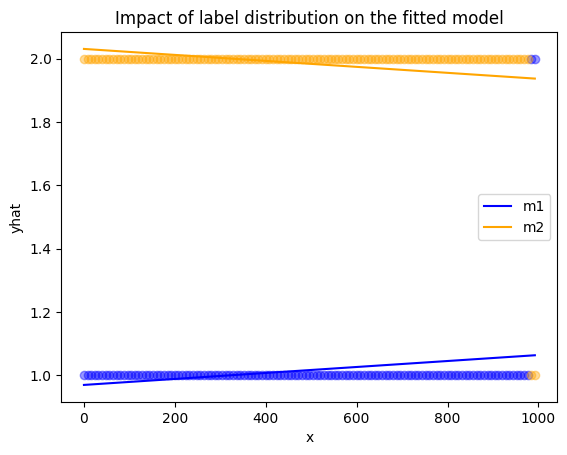

In [ ]:
# x (example feature)
x = np.arange(0, 1000, 8)
x = sm.add_constant(x)

# Response y1 and y2 (two example of datasets)
y1 = np.empty(125)
y2 = np.empty(125)

# Distribution
# -- y1 > y2
y1.fill(1)
y1[-2:] = 2
# -- y1 < y2
y2.fill(2)
y2[-2:] = 1

# Models
m1 = sm.OLS(y1,x)
m2 = sm.OLS(y2,x)
r1 = m1.fit()
r2 = m2.fit()

# Predictions
yhat1 = r1.get_prediction(x).predicted_mean
yhat2 = r2.get_prediction(x).predicted_mean

# Plot
fig, ax = plt.subplots();

# -- data 1 and 2
ax.scatter(x[:, 1], y1, alpha=.4, color='blue');
ax.scatter(x[:, 1], y2, alpha=.4, color='orange');

# -- models 1 and 2
ax.plot(x[:, 1], yhat1, color='blue', label='m1');
ax.plot(x[:, 1], yhat2, color='orange', label='m2');

ax.set_ylabel('yhat');
ax.set_xlabel('x');
ax.set_title('Impact of label distribution on the fitted model');
ax.legend();

Consider now the model `m1`, if we input large `x` (e.g. 1000), we would predict 1.1 which we would translate to label 1 since it is closes to it. This is of course what we do not want our model to learn. In general, it no longer makes sense to have our model minimize the `MSE`. The solution to this is to introduce a new `likelihood` function:

$$
L(\theta, y)=\prod_{i=1}^n\left(p\left(x_i\right)^{y_i}\left(1-p\left(x_i\right)\right)^{1-y_i}\right)
$$

This might look overwhelming at first, but in words it is simple:
- if $$y = 1$$, then make sure $$p(x_i)$$ is as close to 1 as possible
- if $$y = 0$$, then make sure $$p(x_i)$$ is as close to 0 as possible

To find optimal $$\theta$$, there are different numerical optimization techniques:

- iteratively reweighted least squares method (treat as blackbox within this course)
- gradient descent (will be introduced later in the course)

Note, that there is no analytical solution (closed formula) as opposed to the linear regression.


Another problem lies within interpretation of the outpu. What does it mean that our model think for input `x` that the label is 1.1? Yes, you may say it is the `log-odds` but does it really help with interpretation? I personally believe interpretating probability is easier. :)

The desire to have probability motivates the use of `sigmoid` function. This is a function which maps any `x` to a range between 0 and 1. Formally:

$$
\sigma(x) = \frac{1}{1 + e^{-x}}
$$

Let me show you:

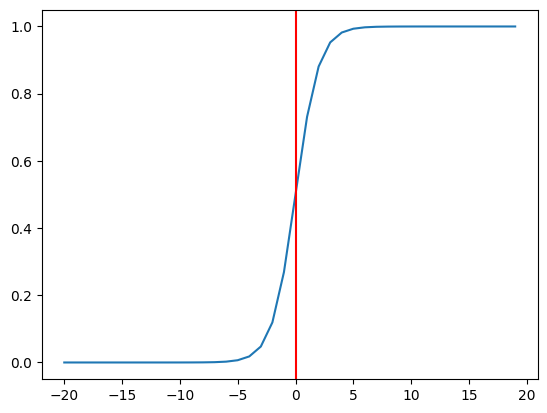

In [ ]:
# Sigmoid function definition
sigmoid = lambda x: (1)/(1 + math.e**(-x))
sigmoidv = np.vectorize(sigmoid) # so we can apply to 1d array

# Create sample data
x = np.arange(-20, 20)
y = sigmoidv(x)

# Plot
fig, ax = plt.subplots();
ax.plot(x, y);
plt.axvline(x=0, color='r');

So now, we can finally interpret the predicted value as `probability`, more specifically probability of class 1 given `x`. Formally:

$$
P(Y = 1 | X) = \sigma(\theta x + \theta_0)
$$

You might have heard that `logistic regression` is a linear model. Well, if we re-arannge the terms we get the following expression:

$$
\log{(\frac{P(Y = 1 | X)}{1 - P(Y = 1 | X)})} = \theta x + \theta_0
$$

On the right, we have our classical linear regression model. On the left we have log-odds (a.k.a. `logit`) Logit function more generally looks as follows:

$$
\operatorname{logit}(p)=\log \frac{p}{1-p} \in \mathbb{R}
$$

In words, we give it a probability and it maps it to `x` which can be any real number. This is why we say `logit` is inverse of sigmoid, just for clarity:

- `sigmoid`: map any real number to a probability
- `logit`: map probability to a real number

Let's implement logit and plot it:

/tmp/ipykernel_4564/2491373323.py:2: RuntimeWarning: divide by zero encountered in log
  logit = lambda p: np.log(p/(1-p))


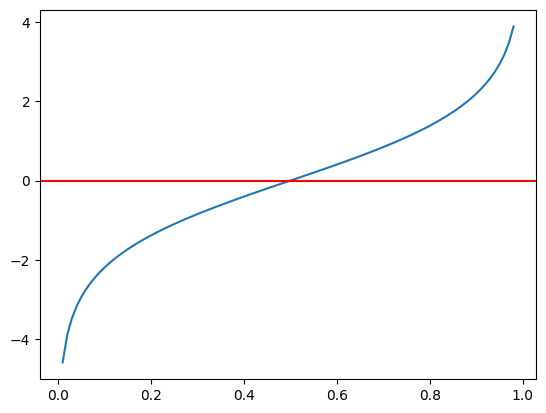

In [ ]:
# Logit implementation
logit = lambda p: np.log(p/(1-p))
logitv = np.vectorize(logit)

# Create sample data
x = np.arange(0, .99, 0.01)
y = logitv(x)

# Plot
fig, ax = plt.subplots();
ax.plot(x, y);
plt.axhline(y=0, color='r');

So how is log-odds useful to us? As I have already mentioned, it nicely shows why `logistic regression` is a linear model. On the contrary, it might be hard to interpret compare to probability which we are all familiar with. But let me give you an easy guide:

- A positive value means something is more likely to occur than to not occur.
- A negative value means something is less likely to occur than to occur.
- Log odds of 0 means something is as likely to occur as not to occur.

For instance, imagine that our input `x` represents skill level of playing beer pong. Our task is to predict, whether the given player will win the game or not. Let's say we get positive log-odds, then the player is more likely to win than lose. How do I know this interpretation, well, let's look at the formula again:

$$
\log{(\frac{P(Y = 1 | X)}{1 - P(Y = 1 | X)})} = \theta x + \theta_0
$$

Look at the numerator and denominator:

- `numerator`: probability of class 1 given X
- `denominator`: probability of class 0 given X

If numerator is equal to denominator we get 1 which is then translated via log to 0 - so equally likely. On the opposite, values greater than 1 mean probability of class 1 is greater than 0 and thus we get positve log-odds. Let's do some conrete computations. Consider a logistic regression model with a single feature $X$ where $\beta_0=0.3$ and $\beta_1=0.7$. What is the probability of $$Y=1$$ when $$X=5$$? Let's use python:

In [ ]:
# Input info
x = 5
b0 = .3
b1 = .7

# Simple linear regression
linr = lambda x: b0 + b1*x

# Compute the result
px5 = sigmoid(linr(x))
print("P(Y = 1 | X = 5) = {:.3f}".format(px5))

P(Y = 1 | X = 5) = 0.978


Now, what are the odds of $$X = 5$$? Well, we know that:

$$
\text{odds} = \frac{p}{1-p}
$$

So we just plug in the obtained probability and get the odds:

In [ ]:
# Odds function definition
odds = lambda p: p/(1 - p)

# Compute the odds
odds_x5 = odds(px5)
print("Odds of X = 5 is {:.3f}".format(odds_x5))

Odds of X = 5 is 44.701


This means that given $$X = 5$$ it is roughly **45 times** more likely that $$Y = 1$$ than $$Y = 0$$. This corresponds to also the high probability that we have inputted. Finally, what is the *odds ratio* comparing odds of $$Y=1$$ when $$X=8$$ to the odds when $$X=5$$?

In [ ]:
# Compute first the odds of x8
px8 = sigmoid(linr(8))
odds_x8 = odds(px8)

# Get the ratio
ratio = odds_x8/odds_x5
print("The odds ratio is {:.3f}".format(ratio))

The odds ratio is 8.166


This means that $$Y = 1$$ is 8 times more likely when $$X = 8$$ compare to $$X = 5$$.

> Section summary

In this section, we discussed thoroughly the general concept of `logistic regression` model. Most important takeaways are:

- Understand why it does not make sense to use as an objective `MSE` to train our `Logistic regression` model. Understand therefore as well what is objective of the new `likelihood function`

- Be able to explain why logistic regression is a linear model - it is just enough to show the rewritten formula and then be able to explain how we interpret the log-odds

### Data preparation and exploration

---


Let's get into actual modelling with Logistic regression. In particular, we will model the relationship between whether the given customer will default (will not repay credit card debt - binary yer or no) based on the explanatory variables - is the customer student, what is the balance on the credit card account, what is the income of the given customer.

In [ ]:
df = pd.read_csv('Default.csv')
df.head()

,default,student,balance,income
0,No,No,729.526495,44361.625074
1,No,Yes,817.180407,12106.134700
2,No,No,1073.549164,31767.138947
3,No,No,529.250605,35704.493935
4,No,No,785.655883,38463.495879


We want to encode the string values for `default` and `student`: 

In [ ]:
enc1 = preprocessing.LabelEncoder()
enc2 = preprocessing.LabelEncoder()

df['default'] = enc1.fit_transform(df['default'])
df['student'] = enc2.fit_transform(df['student'])

df.head()

,default,student,balance,income
0,0,0,729.526495,44361.625074
1,0,1,817.180407,12106.134700
2,0,0,1073.549164,31767.138947
3,0,0,529.250605,35704.493935
4,0,0,785.655883,38463.495879


Let's do some basic data exploration:

In [ ]:
df.describe()

,default,student,balance,income
count,10000.000000,10000.000000,10000.000000,10000.000000
mean,0.033300,0.294400,835.374886,33516.981876
std,0.179428,0.455795,483.714985,13336.639563
min,0.000000,0.000000,0.000000,771.967729
25%,0.000000,0.000000,481.731105,21340.462903
50%,0.000000,0.000000,823.636973,34552.644802
75%,0.000000,1.000000,1166.308386,43807.729272
max,1.000000,1.000000,2654.322576,73554.233495


You can tell that there are some people who literally have no money on their account after they repay the debt so they depend on the loan each month. On the opposite spectrum we have people who are relatively well of and we would expext them not to even need a loan. Let's look more closely on the distribution of the `balances` and `income`:

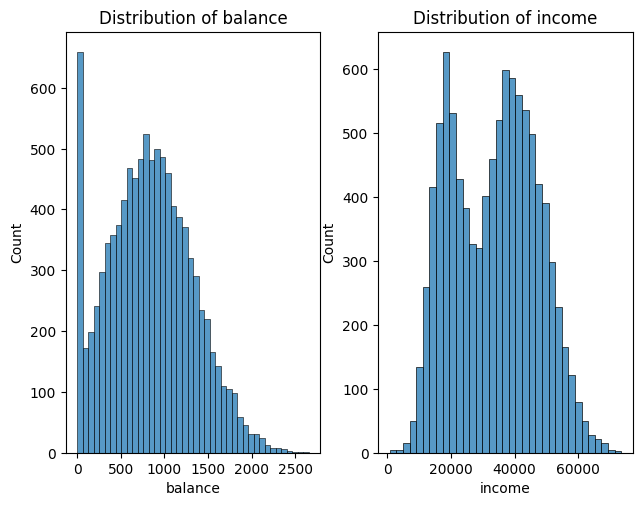

In [ ]:
fig, ax = plt.subplots(1, 2);
fig.tight_layout();

sns.histplot(data=df, x='balance', ax=ax[0]);
ax[0].set_title('Distribution of balance');

sns.histplot(data=df, x='income', ax=ax[1]);
ax[1].set_title('Distribution of income');

Interesting, it seems like `balance` is skewed towards left, i.e., people in general do not have that much money left on the account after they repay the debt. Naturally, I would assume that these will be the people who will be most likely to go default. `Income` seems to be normally distributed as we would expect, altugh the distribution seems to be `bimodal` - this might be however for isntance due to some error in sampling. Let's try to get to know defaulters and non-defaulters more closely:

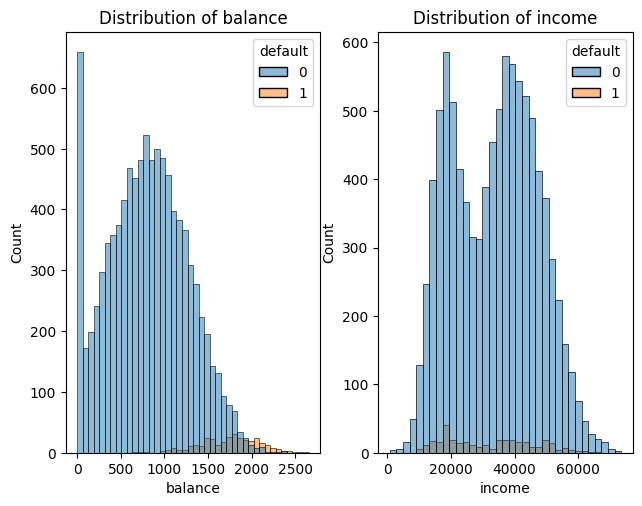

In [ ]:
fig, ax = plt.subplots(1, 2);
fig.tight_layout();

sns.histplot(data=df, x='balance', hue='default', ax=ax[0]);
ax[0].set_title('Distribution of balance');

sns.histplot(data=df, x='income', hue='default', ax=ax[1]);
ax[1].set_title('Distribution of income');

Very surprising when it comes to balance, since people who have left a lot of money on their account after they pay back are the one who end up defaulting. On the opposite site, income is not interesting at all since both distributions overlay. So if we now plot these two features agains each other, we will be able to see that `balance` will be a good differentiator

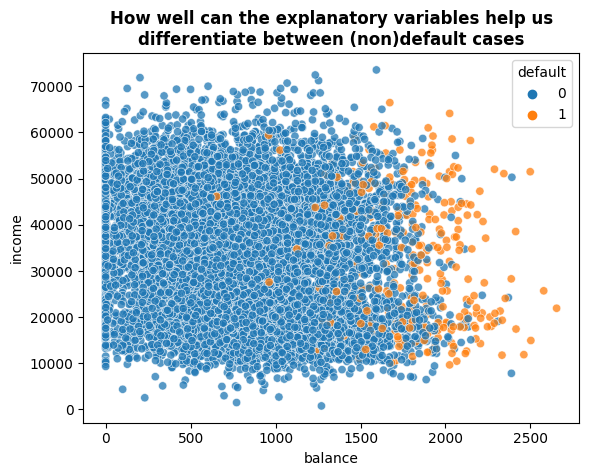

In [ ]:
fig, ax = plt.subplots();

sns.scatterplot(data=df, x='balance', y='income', hue='default', ax=ax, alpha=.75);
ax.set_title('How well can the explanatory variables help us\ndifferentiate between (non)default cases', weight='bold');

As expected, we can see that `income` does not help us at all to differentiate between the two classes. Whereas, `balance` actually does help, we see that if we made a simple rule saying that if your average balance (after you make your monthly debt payment) is less than $1750, than you will not default on your debt (i.e. you keep paying your debts) else you will default. Another interesting thing about our data is the default and non-default people distribution:

In [ ]:
defaulted_customer_count = df[df['default'] == 1].shape[0]
nondefaulted_customer_count = df[df['default'] == 0].shape[0]
print(f"Defaulters count: {defaulted_customer_count}")
print(f"Non-Defaulters count: {nondefaulted_customer_count}")

Defaulters count: 333
Non-Defaulters count: 9667


Uf, that is a high skew. We need to be aware of this when splitting the data since we want to make sure that the training dataset containes enough examples to learn while in the test set we have enough examples to actually see that our model learnt something. Let's see how the fact whether the customer is a student influcences the default variable:

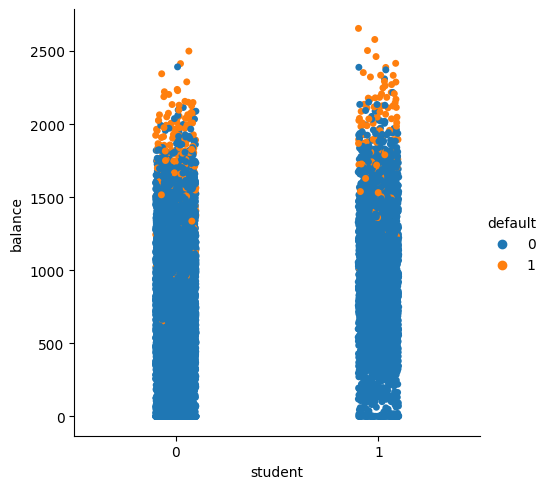

In [ ]:
sns.catplot(data=df, x="student", y="balance", hue='default');

Seems like being a student does not really help either. So overall, it seems like `balance` will be the most importatn feature. We will now split the data into training and test using `sklearn` as last time:

In [ ]:
train, val = train_test_split(df, test_size=.25, random_state=11, stratify=df['default'])

> Section summary

This section is more or less `extra`, but as any experienced data scientist would tell you, you have to first understnand your data before you jump into modelling phase. There is no right way how to get to know your data, what matters is that you do no skip this part of data analysis. :)

### Modelling

---

In this subsection, we are going to create and fit several models using the statsmodel api formula interface. Let's start with a simple model `M1` whose only feature is balance:

In [ ]:
m1 = smf.logit('default ~ balance', data=train)
r1 = m1.fit()

Optimization terminated successfully.
         Current function value: 0.078842
         Iterations 10


Now, we can inspect the results of the fit:

In [ ]:
r1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                default   No. Observations:                 7500
Model:                          Logit   Df Residuals:                     7498
Method:                           MLE   Df Model:                            1
Date:                Sun, 18 Sep 2022   Pseudo R-squ.:                  0.4605
Time:                        23:56:20   Log-Likelihood:                -591.31
converged:                       True   LL-Null:                       -1096.1
Covariance Type:            nonrobust   LLR p-value:                1.511e-221
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -10.7744      0.425    -25.362      0.000     -11.607      -9.942
balance        0.0056      0.000     21.539      0.000       0.005       0.006
==============================================================================

Possibly complete quasi-separation: A fraction 0.14 of observations can be
perfectly predicted. This might indicate that there is complete
quasi-separation. In this case some parameters will not be identified.
"""

As we have assumed, `balance` is very important feature. Seems like that the optimization converged, meaning at least local minimum has been found. Just for a reference, here is how we can fit the exact same model using `sklearn`:

In [ ]:
clf = LogisticRegression(random_state=0, penalty='none').fit(df[['balance']], df['default'])

Just note that you need to use `penalty = none` since by default the model is reguralized. If we were to use the estimated coefficients in an equation for logistic regression model, we would write:

$$
P(Y = 1 | \text{balance}) = \sigma(0.0056\times balance - 10.7744)
$$

where $$\sigma$$ is the **sigmoid** function. Similarly, if we want to know the log odds, we would simply write:

$$
\log(\frac{P(Y = 1 | \text{balance})}{ 1 - P(Y = 1 | \text{balance})}) = 0.0056\times balance - 10.7744
$$

Let's now continue with our model building. We will now go from the feature being `balance` to a new a categorial feature `student`. So in code:

In [ ]:
m2 = smf.logit('default ~ student', data=train)
r2 = m2.fit()
r2.summary()

Optimization terminated successfully.
         Current function value: 0.145587
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                default   No. Observations:                 7500
Model:                          Logit   Df Residuals:                     7498
Method:                           MLE   Df Model:                            1
Date:                Sun, 18 Sep 2022   Pseudo R-squ.:                0.003817
Time:                        23:56:20   Log-Likelihood:                -1091.9
converged:                       True   LL-Null:                       -1096.1
Covariance Type:            nonrobust   LLR p-value:                  0.003818
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -3.4985      0.082    -42.911      0.000      -3.658      -3.339
student        0.3908      0.133      2.942      0.003       0.130       0.651
==============================================================================
"""

If you look at `pseudo R-squared` it is way worse compare to the previous model. This makes sense given the exploratory data analysis that we have done since being student or not does not really `discriminate` between default and non-default cases. Again, if we were to use the estimated coefficients in an equation for logistic regression model, we would write:

$$
P(Y = 1 | \text{student}) = \sigma(0.3908\times balance - 3.4985)
$$

For log odds, we would write:

$$
\log(\frac{P(Y = 1 | \text{student})}{ 1 - P(Y = 1 | \text{student})}) = 0.3908\times balance - 3.4985
$$

Finally, we will fit a model which has an interaction between `balance` and student:

In [ ]:
m3 = smf.logit('default ~ I(student*balance)', data=train)
r3 = m3.fit()
r3.summary()

Optimization terminated successfully.
         Current function value: 0.137906
         Iterations 8


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                default   No. Observations:                 7500
Model:                          Logit   Df Residuals:                     7498
Method:                           MLE   Df Model:                            1
Date:                Sun, 18 Sep 2022   Pseudo R-squ.:                 0.05637
Time:                        23:56:20   Log-Likelihood:                -1034.3
converged:                       True   LL-Null:                       -1096.1
Covariance Type:            nonrobust   LLR p-value:                 1.044e-28
========================================================================================
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               -3.8794      0.090    -43.052      0.000      -4.056      -3.703
I(student * balance)     0.0011   9.27e-05     11.827      0.000       0.001       0.001
========================================================================================
"""

We get slightly better `pseudo r-squared` relative to have only `student` as a feature, but it still sucks compare to using `balance` as a feature. This makes sense because if the customer is not a `student` then we will only rely on the intercept value. And yet again, to write the model in a formula:

$$
P(Y = 1 | \text{student*balance}) = \sigma(0.0011\times student\times balance - 3.8794)
$$

And log odds:

$$
\log(\frac{P(Y = 1 | \text{student*balance})}{ 1 - P(Y = 1 | \text{student*balance})}) = 0.0011\times student\times balance - 3.8794
$$

> Section summary

In this section, the focus was on fitting various modelsa and be able to understand to the outputted summary from `statsmodel`.

### Prediction

---

Let's test our fitted models out. We will be primarily interested in the `training` and `test` error. For this, I am going to create a little utility class:

In [ ]:
class LogisticRegressionSummary:

    def __init__(self, model):
        self.model = model
        self._threshold = .5
    
    def evaluate(self, data, response, metric):
        """Evaluates the given model based on the given metric

        Attributes
        ----------
        data : pandas.DataFrame
            Features with response variable

        response : string
            Name of the response variable
        
        metric : string
            Valid metric name
        """

        # Compute P(Y = 1 | X)
        probabilities = self.model.predict(data)

        # Classify using the given threshold
        yhat = (probabilities > self._threshold).astype(int)
        
        # Parse metrics
        metrics = set(metric.split(','))

        # Report given metric
        if 'error' in metrics:
            error = 1 - accuracy_score(data[response], yhat)
            print("Error for the given dataset is: {:.3f}".format(error))

        if 'f1' in metrics:
            f1 = f1_score(data[response], yhat)
            print("F1 for the given dataset is: {:.3f}".format(f1))
        
        if 'aic' in metrics:
            print("AIC for the given model is: {:.3f}".format(self.model.aic))

And now we can evaluate. Apart from looking at `error` (a.k.a. misclassifation), I also want to look at `f1` which combines `recall` and `precision` of the model. The reason why this is important is that due to imabalance in classes, our model can just predict non default all the time and it will have pretty low error since there is only few defaults. This, however, is then reflected in `f1`:

In [ ]:
print("Summary of model 1 (features: balance)\n---")
sum_m1 = LogisticRegressionSummary(r1)
print('TRAIN')
sum_m1.evaluate(train, 'default', 'error,f1,aic')
print('VAL')
sum_m1.evaluate(val, 'default', 'error,f1,aic')
print()

print("Summary of model 2 (features: student)\n---")
sum_m2 = LogisticRegressionSummary(r2)
print('TRAIN')
sum_m2.evaluate(train, 'default', 'error,f1,aic')
print('VAL')
sum_m2.evaluate(val, 'default', 'error,f1,aic')
print()

print("Summary of model 3 (features: student*balance)\n---")
sum_m3 = LogisticRegressionSummary(r3)
print('TRAIN')
sum_m3.evaluate(train, 'default', 'error,f1,aic')
print('VAL')
sum_m3.evaluate(val, 'default', 'error,f1,aic')
print()

Summary of model 1 (features: balance)
---
TRAIN
Error for the given dataset is: 0.027
F1 for the given dataset is: 0.428
AIC for the given model is: 1186.625
VAL
Error for the given dataset is: 0.028
F1 for the given dataset is: 0.400
AIC for the given model is: 1186.625

Summary of model 2 (features: student)
---
TRAIN
Error for the given dataset is: 0.033
F1 for the given dataset is: 0.000
AIC for the given model is: 2187.803
VAL
Error for the given dataset is: 0.033
F1 for the given dataset is: 0.000
AIC for the given model is: 2187.803

Summary of model 3 (features: student*balance)
---
TRAIN
Error for the given dataset is: 0.033
F1 for the given dataset is: 0.000
AIC for the given model is: 2072.597
VAL
Error for the given dataset is: 0.033
F1 for the given dataset is: 0.000
AIC for the given model is: 2072.597



As expected, we see that overall all models have a very similar and relatively small error rate. In addition, the training and error rates seems to be quite similar which indicates low variance. But if we look at `f1`, we can clearly see that only `m1` is worth considering. This is also confirmed by the model's `AIC` compare to the other two models. One last note, we use the threshold `.5`. In the following lectures about decision theory, you will learn why this is actually the best thing to do in order to reduce the `error rate` under the assumption that costs of missclasifying 1 to 0 and vice versa are equal. If not, then actually different threshold should be used - we will get to this in the upcoming exercises, so do not worry :)

> Section summary

In this section, we evaluated our models. Most important takeaway is that when it comes to imabalanced datasets, you need to use metric like `f1` to get a proper picture of given model's performance.

### Decision regions and the decision boundary between them

---

To get even a better inutition on how our fitted model works, we can visualize its decision boundary. This is usually nicest to see in 2D, i.e., when we have precisely two features. We will try this out in a bit but let's think what would be the decision boundaries of our `m1` model (features: balance)? We can write a simple script that answers this question:

In [ ]:
# Define possible balances
balances = np.arange(0, 5000, 50)

# Define decision function
probs = lambda x: m1.predict(params=r1.params, exog=[1, x])
predict = lambda x: 1 if m1.predict(params=r1.params, exog=[1, x]) > 0.5 else 0

# Vectorize the functions
probsv = np.vectorize(probs)
predictv = np.vectorize(predict)

# Get predictions
yhat = predictv(balances)
confidences = probsv(balances)

# Show the results
print("Balance | Prediction | Confidence")
print("- "*17)
for i in range(len(balances)):
    print("{:^7} | {:^10} | {:^10.5f}".format(balances[i], yhat[i], confidences[i]))
    print("- "*17)

Balance | Prediction | Confidence
- - - - - - - - - - - - - - - - - 
   0    |     0      |  0.00002  
- - - - - - - - - - - - - - - - - 
  50    |     0      |  0.00003  
- - - - - - - - - - - - - - - - - 
  100   |     0      |  0.00004  
- - - - - - - - - - - - - - - - - 
  150   |     0      |  0.00005  
- - - - - - - - - - - - - - - - - 
  200   |     0      |  0.00006  
- - - - - - - - - - - - - - - - - 
  250   |     0      |  0.00008  
- - - - - - - - - - - - - - - - - 
  300   |     0      |  0.00011  
- - - - - - - - - - - - - - - - - 
  350   |     0      |  0.00015  
- - - - - - - - - - - - - - - - - 
  400   |     0      |  0.00019  
- - - - - - - - - - - - - - - - - 
  450   |     0      |  0.00026  
- - - - - - - - - - - - - - - - - 
  500   |     0      |  0.00034  
- - - - - - - - - - - - - - - - - 
  550   |     0      |  0.00044  
- - - - - - - - - - - - - - - - - 
  600   |     0      |  0.00059  
- - - - - - - - - - - - - - - - - 
  650   |     0      |  0.00077  


This nicely shows that once the `balance` is roughly more than $1925, model predicts `default` otherwise `non-default`. Let's now consider a new model `m4` that has two features `balance` and `income`. I will fit this model in `sklearn` since it can be integrated with an exteranl library called `mlxtend` (make sure you pip install it if you want to run the code below):

In [ ]:
# Split the features and response into separate variables
X_train, y_train = train[['balance', 'income']].to_numpy(), train['default'].to_numpy()
X_val, y_val = val[['balance', 'income']].to_numpy(), val['default'].to_numpy()

# Fit the model
m4 = LogisticRegression(penalty='none').fit(X_train, y_train)

We can now plot the decision boundary of the model `m4` in a 2D grid:

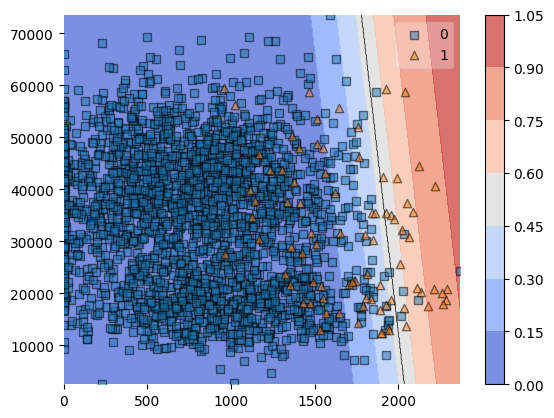

In [ ]:
# -- Data preparation
# define bounds of the domain
min1, max1 = X_val[:, 0].min()-1, X_val[:, 0].max()+1
min2, max2 = X_val[:, 1].min()-1, X_val[:, 1].max()+1

# define the x and y scale
x1grid = np.arange(min1, max1, 5)
x2grid = np.arange(min2, max2, 5)

# create all of the lines and rows of the grid
xx, yy = np.meshgrid(x1grid, x2grid)

# flatten each grid to a vector
rr1, rr2 = xx.flatten(), yy.flatten()
rr1, rr2 = rr1.reshape((len(rr1), 1)), rr2.reshape((len(rr2), 1))

# horizontal stack vectors to create x1,x2 input for the model
grid = np.hstack((rr1,rr2))

# make predictions for the grid
yhat = m4.predict_proba(grid)

# keep just the probabilities for class 1
yhat = yhat[:, 1]

# reshape the predictions back into a grid
zz = yhat.reshape(xx.shape)

# -- Plotting
fig, ax = plt.subplots();

# plot the grid of x, y and z values as a surface
c = ax.contourf(xx, yy, zz, cmap='coolwarm', alpha=.75)

# add a legend, called a color bar
plt.colorbar(c)

# Show decision boundary and points
plot_decision_regions(X_val, y_val, clf=m4, legend=1, ax=ax, contourf_kwargs={'alpha': 0}, scatter_kwargs={'alpha': .5});

Let's try to add some non-linearity to our model through the `polynomial features`, the decision boundary should become also non-linear then:

/root/venv/lib/python3.9/site-packages/mlxtend/plotting/decision_regions.py:269: UserWarning: No contour levels were found within the data range.
  ax.contour(xx, yy, Z, cset.levels, **contour_kwargs)


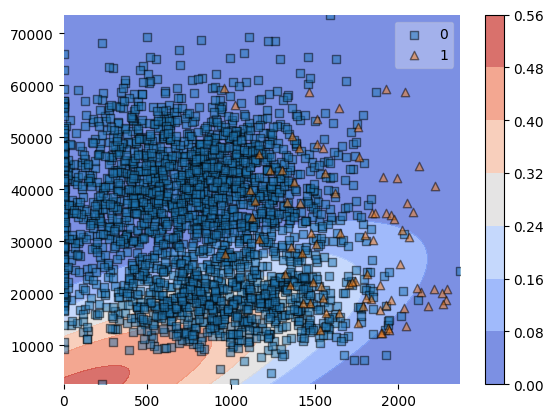

In [ ]:
# -- Fit the newl model
m5 = make_pipeline(PolynomialFeatures(degree=2), LogisticRegression(penalty='none')).fit(X_train, y_train)

# -- Data preparation
# make predictions for the grid
yhat = m5.predict_proba(grid)

# keep just the probabilities for class 1
yhat = yhat[:, 1]

# reshape the predictions back into a grid
zz = yhat.reshape(xx.shape)

# -- Plotting
fig, ax = plt.subplots();

# plot the grid of x, y and z values as a surface
c = ax.contourf(xx, yy, zz, cmap='coolwarm', alpha=.75)

# add a legend, called a color bar
plt.colorbar(c)

# Show decision boundary and points
plot_decision_regions(X_val, y_val, clf=m5, legend=1, ax=ax, contourf_kwargs={'alpha': 0}, scatter_kwargs={'alpha': .5});

> Section summary

This section objective was to **visualize** decision regions of our models also with respect to the confidence in the given prediction. From a theoretical standpoint, you should remember that by adding any non-linearity to the features, the decision boundary will indeed also become non-linear. Another objective was to challenge you a bit codewise since you need to understand how grid works and then how to use it to make predictions etc. This will become handy in the project phase.

### Interpreting a model


---

In this very last section, we will try to play around bit more with our fitted models and as such get a better understanding of them. Let's try to first predict probability of default for the following two individuals:

In [ ]:
# Define two customers
balances = np.array([[1, 1000], [1, 2000]])

# Get probabilities of defaulting
probs = m1.predict(params=r1.params, exog=balances)

print("Customer 1 (balance=1000) probability of default: {:.5f}".format(probs[0]))
print("Customer 2 (balance=2000) probability of default: {:.5f}".format(probs[1]))

Customer 1 (balance=1000) probability of default: 0.00539
Customer 2 (balance=2000) probability of default: 0.58423


If we recall the model's equation:

$$
P(Y = 1 | \text{balance}) = \sigma(0.0056\times balance - 10.7744)
$$

Then we can also compute this by manually:

In [ ]:
# Define the equation in python
sigmoid = lambda x: 1/(1 + math.e**(-x))
lr = lambda x: .0056*x - 10.7744

# Compute the probs
p1, p2 = sigmoid(lr(1000)), sigmoid(lr(2000))

print("Customer 1 (balance=1000) probability of default: {:.5f}".format(p1))
print("Customer 2 (balance=2000) probability of default: {:.5f}".format(p2))

Customer 1 (balance=1000) probability of default: 0.00563
Customer 2 (balance=2000) probability of default: 0.60482


Plus minus some rounding error, looks about right :) Let's now consider the `odds` ratio, i.e., how much more likely is the customer with a higher balance to default than a customer with lower balance:

In [ ]:
odds_ratio = odds(p2)/odds(p1)
print("Odds ratio Customer 2 (balance=2000) vs Customer 1 (balance=1000): {:.3f}".format(odds_ratio))

Odds ratio Customer 2 (balance=2000) vs Customer 1 (balance=1000): 270.426


So customer 2 is `270x` more likely to default than the customer 1 with balance $1000. Lastly with regards to `m1`, how should we interpret the coefficient for balance - `.0056`? If we change a `balance` by a tiny bit (unit change), then as a result log-odds will change by a factor of `.0056`. As we know, the higher the log-odds the higher the probability of default and vice versa.

Let's now inspect more `m2` and probability of defaulting for students and non-students:

In [ ]:
# Define two customers
students = np.array([[1, 0], [1, 1]])

# Get probabilities of defaulting
probs = m2.predict(params=r2.params, exog=students)

print("Customer 1 (student=0) probability of default: {:.5f}".format(probs[0]))
print("Customer 2 (student=1) probability of default: {:.5f}".format(probs[1]))

Customer 1 (student=0) probability of default: 0.02936
Customer 2 (student=1) probability of default: 0.04279


That seems to make sense in a real life context that a student is more likely to default. Finally, let's inspect the `m3`:

In [ ]:
# Define four customers
customers = np.array([[1, 1*1000], [1, 1*2000], [1, 0*1000], [1, 0*2000]])

# Get probabilities of defaulting
probs = m3.predict(params=r3.params, exog=customers)

print("Customer 1 (student=1, balance=1000) probability of default: {:.5f}".format(probs[0]))
print("Customer 2 (student=1, balance=2000) probability of default: {:.5f}".format(probs[1]))
print("Customer 3 (student=0, balance=1000) probability of default: {:.5f}".format(probs[2]))
print("Customer 4 (student=0, balance=2000) probability of default: {:.5f}".format(probs[3]))

Customer 1 (student=1, balance=1000) probability of default: 0.05823
Customer 2 (student=1, balance=2000) probability of default: 0.15611
Customer 3 (student=0, balance=1000) probability of default: 0.02024
Customer 4 (student=0, balance=2000) probability of default: 0.02024


Interestingly, despite the **customers 3 and 4** being different, their probability of default is the same. This makes since the non-student term cancels the balance out of the picture. Let's inspect the odds ratio of low vs high balance student and similarly for non-students:

In [ ]:
ratio1 = odds(probs[1])/odds(probs[0])
ratio2 = odds(probs[3])/odds(probs[2])

print("Odds ratio high vs low balance student: {:.3f}".format(ratio1))
print("Odds ratio high vs low balance non-student: {:.3f}".format(ratio2))

Odds ratio high vs low balance student: 2.992
Odds ratio high vs low balance non-student: 1.000


The result corresponds to what we would expect given the computed probabilities above. By its definition, the interaction term makes no difference between low and high balance non-student customers. 

> Section summary

This section again was bit mote theoretical. Its objective was to play around with the fitted models, inspect their behaviour as well as inspecting the fitted parameters and their interpretation.

---

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=f55a14af-bbab-416e-a503-0d36b8d84571' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>